In [112]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import IPython
import IPython.display
import pandas as pd
import numpy as np
import math
import scipy
import tempfile
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler

# Make numpcy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.keras.utils import to_categorical #type: ignore
import matplotlib.pyplot as plt
import matplotlib as mat
#import colordict as cd
import seaborn as sns

from flowability_data_upload.Research import main
from flowability_data_upload.Research.main import trymodel, makemodel, modeltest

from statsmodels.graphics.regressionplots import abline_plot

from flowability_data_upload.Research.main import trymodel, makemodel, modeltest, Data

import matplotlib.pyplot as plt
from matplotlib import cm  
from mpl_toolkits.mplot3d import Axes3D


In [113]:
%matplotlib inline  
%matplotlib notebook

In [114]:
%%capture

def load_data():
    x = Data()
    x.importnewpowders()
    df_data = pd.DataFrame(x.data)
    df_flow = pd.DataFrame(x.flow)
    df_noflow = pd.DataFrame(x.noflow)

    return df_data, df_flow, df_noflow

df_data, df_flow, df_noflow = load_data()

In [115]:
pd.set_option('display.max_columns', None)
df_data.describe()

,Da,Dp,FWidth,FLength,ELength,EWidth,Volume,Area,Perimeter,CHull Area,CHull Perimeter,Sphericity,Compactness,Roundness,Ellipse Ratio,Circularity,Solidity,Concavity,Convexity,Extent,Transparency,Curvature,Surface Area,L/W Ratio,W/L Aspect Ratio,CHull Surface Area,Ellipticity,Flow,Flow Class
count,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,2.714330e+05,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000
mean,17.437426,19.584505,16.006094,20.989617,20.064784,15.574809,1.194712e+04,394.803286,61.526533,417.306852,58.768829,0.899650,0.831908,0.699995,0.794656,0.813635,0.944927,0.055073,0.969058,0.711475,0.369702,0.030291,1579.213144,1.348371,0.769345,1669.227407,1.321048,17.321739,0.557965
std,14.093120,16.539802,12.996290,17.264877,17.008509,12.737594,8.588047e+04,897.617276,51.961316,966.819265,47.467115,0.065308,0.089029,0.141272,0.148346,0.112077,0.046066,0.046066,0.034497,0.052250,0.059026,0.205644,3590.469105,0.303105,0.129415,3867.277062,0.359398,19.867035,0.496630
min,2.579000,3.620000,3.000000,3.840000,2.950000,2.067000,8.985000e+00,5.225000,11.373000,7.423000,11.046000,0.435000,0.291000,0.084000,0.098000,0.189000,0.700000,0.000000,0.548000,0.380000,0.000000,0.000000,20.900000,1.015000,0.124000,29.692000,1.000000,0.000000,0.000000
25%,8.120000,8.978000,7.462000,9.802000,9.166000,7.170000,2.803440e+02,51.787000,28.206000,54.896000,27.675000,0.867000,0.780000,0.608000,0.709000,0.752000,0.928000,0.024000,0.959000,0.686000,0.333000,0.000000,207.147000,1.150000,0.693000,219.583000,1.097000,0.000000,0.000000
50%,12.486000,13.765000,11.378000,14.978000,14.183000,11.128000,1.019258e+03,122.447000,43.244000,129.397000,42.106000,0.917000,0.850000,0.722000,0.832000,0.841000,0.958000,0.042000,0.982000,0.722000,0.383000,0.000000,489.787000,1.255000,0.797000,517.590000,1.201000,14.430000,1.000000
75%,22.466000,24.995000,20.670000,26.623000,25.589000,20.080000,5.936972e+03,396.400000,78.524000,419.254000,75.287000,0.949000,0.900000,0.810000,0.911000,0.900000,0.976000,0.072000,0.992000,0.748000,0.416000,0.000000,1585.602000,1.442000,0.869000,1677.015000,1.410000,34.310000,1.000000
max,395.289000,841.622000,375.143000,514.872000,473.644000,371.279000,3.234010e+07,122720.860000,2644.034000,145923.674000,1448.384000,0.993000,0.987000,0.974000,1.000000,0.986000,1.000000,0.300000,1.000000,0.894000,0.674000,6.250000,490883.440000,8.085000,0.985000,583694.696000,10.246000,64.303333,1.000000


# Training Classifiers

## Flow Class Prediction

In [116]:
#Flow Class Imbalance

neg, pos = np.bincount(df_data['Flow Class']) #type: ignore
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 271433
    Positive: 151450 (55.80% of total)



### Data Cleaning

In [117]:
cleaned_df = df_data.copy().reset_index(drop = True)

powder = cleaned_df.pop('Flow')
powder = cleaned_df.pop('Powder')

## Model Class

In [118]:
class Model:
    def __init__(self, name, num_classes = 2):
        self.name = name
        self.num_classes = num_classes

        self.EPOCHS = 100
        self.BATCH_SIZE = 2048
        

In [119]:
regular_model = Model(name = "Regular")
boxcox_model = Model(name="Boxcox Transform")

### Train Test Split

In [120]:
def split_transform_data(self, cleaned_df, target = 'Flow Class', use_boxcox = False):
    # Use a utility from sklearn to split and shuffle your dataset.
    train_df, self.test_df = train_test_split(cleaned_df, test_size=0.2)

    if use_boxcox:
        for col in train_df.columns[:-1]: #all except last (assuming target)
            fit_values, fit_lambda = scipy.stats.boxcox(train_df[col].values + 0.0001)
            train_df[col] = fit_values
            self.test_df[col] = scipy.stats.boxcox(self.test_df[col].values + 0.0001, fit_lambda)

    self.train_df, self.val_df = train_test_split(train_df, test_size=0.2)

    # Form np arrays of labels and features.
    self.train_labels = np.array(self.train_df.pop(target))
    self.bool_train_labels = self.train_labels != 0
    self.val_labels = np.array(self.val_df.pop(target))
    self.test_labels = np.array(self.test_df.pop(target))

    self.train_features = np.array(self.train_df)
    self.val_features = np.array(self.val_df)
    self.test_features = np.array(self.test_df)
      

Model.split_transform_data = split_transform_data

In [121]:
regular_model.split_transform_data(cleaned_df, use_boxcox=False)
boxcox_model.split_transform_data(cleaned_df, use_boxcox=True)

### Apply Standard Scaling

In [122]:
def apply_Scaler(self):
    scaler = MinMaxScaler()
    self.train_features = scaler.fit_transform(self.train_features)

    self.val_features = scaler.transform(self.val_features)
    self.test_features = scaler.transform(self.test_features)

    self.train_features = np.clip(self.train_features, -5, 5)
    self.val_features = np.clip(self.val_features, -5, 5)
    self.test_features = np.clip(self.test_features, -5, 5)


    print('Training labels shape:', self.train_labels.shape)
    print('Validation labels shape:', self.val_labels.shape)
    print('Test labels shape:', self.test_labels.shape)

    print('Training features shape:', self.train_features.shape)
    print('Validation features shape:', self.val_features.shape)
    print('Test features shape:', self.test_features.shape)

Model.apply_Scaler = apply_Scaler

In [123]:
regular_model.apply_Scaler()
boxcox_model.apply_Scaler()

Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)
Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)


### Define Model and Metrics

In [124]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

Model.METRICS = METRICS

def make_model(self, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    self.model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(self.train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    self.model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=self.METRICS)

    return self.model

Model.make_model = make_model

def evaluate_model(self):
    results = self.model.evaluate(self.train_features, self.train_labels, batch_size = self.BATCH_SIZE, verbose=0)
    print("Loss: {:0.4f}".format(results[0]))

Model.evaluate_model = evaluate_model

def fit_model(self):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_prc', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

    self.history = self.model.fit(
        self.train_features,
        self.train_labels,
        batch_size=self.BATCH_SIZE,
        epochs=self.EPOCHS,
        callbacks=[early_stopping],
        validation_data=(self.val_features, self.val_labels))

    return self.history

Model.fit_model = fit_model

def predict(self, input):
    # make predictions on the input data using the model
    scaler = StandardScaler()
    scaled_input = scaler.fit_transform(input)

    predictions = self.model.predict(scaled_input)
    
    return predictions

Model.predict = predict
  
def create_model():

    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(27,)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

    return model

### Visualization

In [125]:
def visualize(self):
    pos_df = pd.DataFrame(self.train_features[self.bool_train_labels], columns=self.train_df.columns)
    neg_df = pd.DataFrame(self.train_features[~self.bool_train_labels], columns=self.train_df.columns)

    f1,f2 = np.random.choice(self.train_df.columns, 2, replace=False)

    sns.jointplot(x=pos_df[f1], y=pos_df[f2],
                kind='hex', xlim=(-5,5), ylim=(-5,5))
    plt.suptitle("Positive distribution")

    sns.jointplot(x=neg_df[f1], y=neg_df[f2],
                kind='hex', xlim=(-5,5), ylim=(-5,5))
    _ = plt.suptitle("Negative distribution")

Model.visualize = visualize

def plot_metrics(self):

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(self.history.epoch, self.history.history[metric], color=colors[0], label='Train')
        plt.plot(self.history.epoch, self.history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()

Model.plot_metrics = plot_metrics

def plot_cm(self, p=0.5):
    predictions = self.model.predict(self.test_features)
    cm = confusion_matrix(self.test_labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No Flow Detected (True Negatives): ', cm[0][0])
    print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
    print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
    print('Flow Detected (True Positives): ', cm[1][1])
    print('Total Flow Detected: ', np.sum(cm[1]))

    print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

Model.plot_cm = plot_cm

## Baseline Model

In [126]:
baseline = Model(name = "Baseline Model", num_classes= 2)

baseline.split_transform_data(cleaned_df, use_boxcox=False)

baseline.apply_Scaler()

Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)


In [127]:
first_model = baseline.make_model()
history = baseline.fit_model()
baseline.evaluate_model()

Epoch 1/100
85/85 [==============================] - 3s 12ms/step - loss: 0.7592 - tp: 29991.0000 - fp: 21920.0000 - tn: 54943.0000 - fn: 66862.0000 - accuracy: 0.4889 - precision: 0.5777 - recall: 0.3097 - auc: 0.5155 - prc: 0.5760 - val_loss: 0.6932 - val_tp: 6706.0000 - val_fp: 2784.0000 - val_tn: 16380.0000 - val_fn: 17560.0000 - val_accuracy: 0.5316 - val_precision: 0.7066 - val_recall: 0.2764 - val_auc: 0.5974 - val_prc: 0.6701
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.7302 - tp: 43211.0000 - fp: 31599.0000 - tn: 45264.0000 - fn: 53642.0000 - accuracy: 0.5093 - precision: 0.5776 - recall: 0.4462 - auc: 0.5340 - prc: 0.6007 - val_loss: 0.6782 - val_tp: 10859.0000 - val_fp: 4186.0000 - val_tn: 14978.0000 - val_fn: 13407.0000 - val_accuracy: 0.5949 - val_precision: 0.7218 - val_recall: 0.4475 - val_auc: 0.6567 - val_prc: 0.7322
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.7151 - tp: 44839.0000 - fp: 32230.0000 - tn: 4463

Epoch 20/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6113 - tp: 60211.0000 - fp: 20093.0000 - tn: 56770.0000 - fn: 36642.0000 - accuracy: 0.6734 - precision: 0.7498 - recall: 0.6217 - auc: 0.7255 - prc: 0.7681 - val_loss: 0.5836 - val_tp: 16901.0000 - val_fp: 4890.0000 - val_tn: 14274.0000 - val_fn: 7365.0000 - val_accuracy: 0.7178 - val_precision: 0.7756 - val_recall: 0.6965 - val_auc: 0.7666 - val_prc: 0.8006
Epoch 21/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6107 - tp: 60144.0000 - fp: 20356.0000 - tn: 56507.0000 - fn: 36709.0000 - accuracy: 0.6715 - precision: 0.7471 - recall: 0.6210 - auc: 0.7288 - prc: 0.7691 - val_loss: 0.5834 - val_tp: 16788.0000 - val_fp: 4810.0000 - val_tn: 14354.0000 - val_fn: 7478.0000 - val_accuracy: 0.7171 - val_precision: 0.7773 - val_recall: 0.6918 - val_auc: 0.7666 - val_prc: 0.8004
Epoch 22/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6100 - tp: 60058.0000 - fp: 20175.0000 - tn: 566

Epoch 39/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5982 - tp: 76899.0000 - fp: 36351.0000 - tn: 40512.0000 - fn: 19954.0000 - accuracy: 0.6759 - precision: 0.6790 - recall: 0.7940 - auc: 0.7464 - prc: 0.7814 - val_loss: 0.5739 - val_tp: 18007.0000 - val_fp: 6044.0000 - val_tn: 13120.0000 - val_fn: 6259.0000 - val_accuracy: 0.7167 - val_precision: 0.7487 - val_recall: 0.7421 - val_auc: 0.7703 - val_prc: 0.8042
Epoch 40/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5984 - tp: 76878.0000 - fp: 36270.0000 - tn: 40593.0000 - fn: 19975.0000 - accuracy: 0.6762 - precision: 0.6794 - recall: 0.7938 - auc: 0.7462 - prc: 0.7811 - val_loss: 0.5755 - val_tp: 17997.0000 - val_fp: 6004.0000 - val_tn: 13160.0000 - val_fn: 6269.0000 - val_accuracy: 0.7174 - val_precision: 0.7498 - val_recall: 0.7417 - val_auc: 0.7705 - val_prc: 0.8042
Epoch 41/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5975 - tp: 76863.0000 - fp: 36180.0000 - tn: 406

Epoch 58/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5965 - tp: 77015.0000 - fp: 36363.0000 - tn: 40500.0000 - fn: 19838.0000 - accuracy: 0.6765 - precision: 0.6793 - recall: 0.7952 - auc: 0.7480 - prc: 0.7824 - val_loss: 0.5735 - val_tp: 18290.0000 - val_fp: 6325.0000 - val_tn: 12839.0000 - val_fn: 5976.0000 - val_accuracy: 0.7168 - val_precision: 0.7430 - val_recall: 0.7537 - val_auc: 0.7711 - val_prc: 0.8051
Epoch 59/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5968 - tp: 76959.0000 - fp: 36340.0000 - tn: 40523.0000 - fn: 19894.0000 - accuracy: 0.6763 - precision: 0.6793 - recall: 0.7946 - auc: 0.7480 - prc: 0.7826 - val_loss: 0.5724 - val_tp: 17809.0000 - val_fp: 5693.0000 - val_tn: 13471.0000 - val_fn: 6457.0000 - val_accuracy: 0.7202 - val_precision: 0.7578 - val_recall: 0.7339 - val_auc: 0.7716 - val_prc: 0.8053
Epoch 60/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5967 - tp: 76857.0000 - fp: 36345.0000 - tn: 405

Epoch 77/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5966 - tp: 76891.0000 - fp: 36130.0000 - tn: 40733.0000 - fn: 19962.0000 - accuracy: 0.6771 - precision: 0.6803 - recall: 0.7939 - auc: 0.7477 - prc: 0.7820 - val_loss: 0.5727 - val_tp: 18055.0000 - val_fp: 5954.0000 - val_tn: 13210.0000 - val_fn: 6211.0000 - val_accuracy: 0.7199 - val_precision: 0.7520 - val_recall: 0.7440 - val_auc: 0.7724 - val_prc: 0.8058
Epoch 78/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5947 - tp: 76983.0000 - fp: 36059.0000 - tn: 40804.0000 - fn: 19870.0000 - accuracy: 0.6780 - precision: 0.6810 - recall: 0.7948 - auc: 0.7500 - prc: 0.7840 - val_loss: 0.5714 - val_tp: 17605.0000 - val_fp: 5359.0000 - val_tn: 13805.0000 - val_fn: 6661.0000 - val_accuracy: 0.7232 - val_precision: 0.7666 - val_recall: 0.7255 - val_auc: 0.7727 - val_prc: 0.8059
Epoch 79/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5959 - tp: 76925.0000 - fp: 35816.0000 - tn: 410

Epoch 96/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5914 - tp: 69998.0000 - fp: 25116.0000 - tn: 51747.0000 - fn: 26855.0000 - accuracy: 0.7008 - precision: 0.7359 - recall: 0.7227 - auc: 0.7546 - prc: 0.7871 - val_loss: 0.5702 - val_tp: 17608.0000 - val_fp: 5311.0000 - val_tn: 13853.0000 - val_fn: 6658.0000 - val_accuracy: 0.7244 - val_precision: 0.7683 - val_recall: 0.7256 - val_auc: 0.7735 - val_prc: 0.8064
Epoch 97/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5926 - tp: 70028.0000 - fp: 25048.0000 - tn: 51815.0000 - fn: 26825.0000 - accuracy: 0.7014 - precision: 0.7365 - recall: 0.7230 - auc: 0.7536 - prc: 0.7858 - val_loss: 0.5724 - val_tp: 18015.0000 - val_fp: 5825.0000 - val_tn: 13339.0000 - val_fn: 6251.0000 - val_accuracy: 0.7219 - val_precision: 0.7557 - val_recall: 0.7424 - val_auc: 0.7732 - val_prc: 0.8062
Epoch 98/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5929 - tp: 70016.0000 - fp: 24870.0000 - tn: 519

<IPython.core.display.Javascript object>


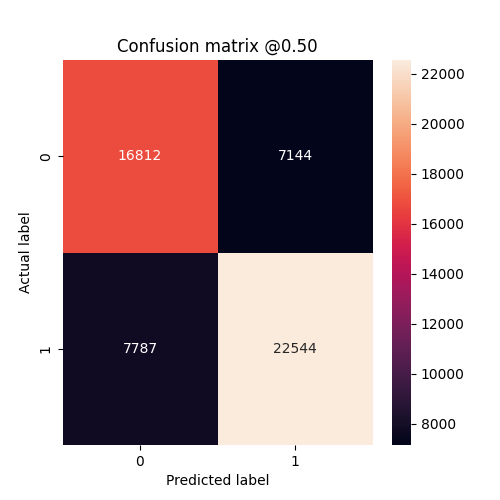

No Flow Detected (True Negatives):  16812
Flow Incorrectly Detected (False Positives):  7144
No Flow Incorrectly Detected (False Negatives):  7787
Flow Detected (True Positives):  22544
Total Flow Detected:  30331
0.7249617772210658


In [128]:
baseline.plot_cm()

### Resampling

In [129]:
def resample(df_data, target = "Powder", n = 10000):
    grouped_df = df_data.groupby('Powder')
    # create a new dataframe to hold the resampled rows
    resampled_df = pd.DataFrame()

    # for each group in the grouped dataframe
    for name, group in grouped_df:
        # if the number of rows in the group is greater than n
        if len(group) > n:
            # undersample the group without replacement
            resampled_group = group.sample(n=n, replace=False)
        else:
            # oversample the group with replacement
            resampled_group = group.sample(n=n, replace=True)
        # append the resampled group to the resampled dataframe
        resampled_df = pd.concat([resampled_df, resampled_group], axis = 0)

    # print the resampled dataframe
    resampled_df = resampled_df.reset_index(drop = True)

    return resampled_df

In [130]:
resampled_df = resample(df_data)


le = LabelEncoder()
resampled_df['Powder Class'] = le.fit_transform(resampled_df['Powder'])#type: ignore
num_classes = len(le.classes_)
counts = np.bincount(resampled_df['Powder Class']) 
total = sum(counts)

for label,count in zip(le.classes_,counts):
    print(f"Label {label} : {count} ({count/total * 100:.2f}% of total)")
    break

resampled_df.pop('Powder')
resampled_df.pop('Flow Class')
resampled_df.pop('Flow')

class_labels = resampled_df.pop('Powder Class')

Label AEE_WP-301_1-5_AA_3-7.txt : 10000 (3.03% of total)


## Flow Class Resample

In [131]:
powder_balanced_df = resample(df_data)
powder_balanced_df.pop("Powder")
powder_balanced_df.pop("Flow")

neg, pos = np.bincount(powder_balanced_df['Flow Class']) #type: ignore
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 330000
    Positive: 240000 (72.73% of total)



In [132]:
balanced_model = Model(name = "Balanced Model", num_classes= 2)

balanced_model.split_transform_data(powder_balanced_df)

balanced_model.apply_Scaler()

Training labels shape: (211200,)
Validation labels shape: (52800,)
Test labels shape: (66000,)
Training features shape: (211200, 27)
Validation features shape: (52800, 27)
Test features shape: (66000, 27)


In [133]:
model = balanced_model.make_model()
history = balanced_model.fit_model()
balanced_model.evaluate_model()

Epoch 1/100
104/104 [==============================] - 2s 10ms/step - loss: 0.5585 - tp: 224293.0000 - fp: 79565.0000 - tn: 54914.0000 - fn: 26144.0000 - accuracy: 0.7254 - precision: 0.7382 - recall: 0.8956 - auc: 0.7322 - prc: 0.8255 - val_loss: 0.5013 - val_tp: 38586.0000 - val_fp: 14189.0000 - val_tn: 10.0000 - val_fn: 15.0000 - val_accuracy: 0.7310 - val_precision: 0.7311 - val_recall: 0.9996 - val_auc: 0.7794 - val_prc: 0.9152
Epoch 2/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4975 - tp: 148699.0000 - fp: 51345.0000 - tn: 6271.0000 - fn: 4885.0000 - accuracy: 0.7338 - precision: 0.7433 - recall: 0.9682 - auc: 0.7594 - prc: 0.9029 - val_loss: 0.4749 - val_tp: 37902.0000 - val_fp: 13035.0000 - val_tn: 1164.0000 - val_fn: 699.0000 - val_accuracy: 0.7399 - val_precision: 0.7441 - val_recall: 0.9819 - val_auc: 0.7840 - val_prc: 0.9166
Epoch 3/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4845 - tp: 145598.0000 - fp: 47692.0000 - tn: 992

Epoch 20/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4673 - tp: 143739.0000 - fp: 43653.0000 - tn: 13963.0000 - fn: 9845.0000 - accuracy: 0.7467 - precision: 0.7670 - recall: 0.9359 - auc: 0.7876 - prc: 0.9160 - val_loss: 0.4588 - val_tp: 35879.0000 - val_fp: 10182.0000 - val_tn: 4017.0000 - val_fn: 2722.0000 - val_accuracy: 0.7556 - val_precision: 0.7789 - val_recall: 0.9295 - val_auc: 0.7916 - val_prc: 0.9193
Epoch 21/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4672 - tp: 143892.0000 - fp: 43564.0000 - tn: 14052.0000 - fn: 9692.0000 - accuracy: 0.7478 - precision: 0.7676 - recall: 0.9369 - auc: 0.7877 - prc: 0.9160 - val_loss: 0.4592 - val_tp: 36200.0000 - val_fp: 10564.0000 - val_tn: 3635.0000 - val_fn: 2401.0000 - val_accuracy: 0.7545 - val_precision: 0.7741 - val_recall: 0.9378 - val_auc: 0.7918 - val_prc: 0.9193
Epoch 22/100
104/104 [==============================] - 0s 3ms/step - loss: 0.4668 - tp: 143889.0000 - fp: 43662.0000 - 

Epoch 39/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4661 - tp: 143605.0000 - fp: 43192.0000 - tn: 14424.0000 - fn: 9979.0000 - accuracy: 0.7482 - precision: 0.7688 - recall: 0.9350 - auc: 0.7888 - prc: 0.9166 - val_loss: 0.4578 - val_tp: 35625.0000 - val_fp: 9830.0000 - val_tn: 4369.0000 - val_fn: 2976.0000 - val_accuracy: 0.7575 - val_precision: 0.7837 - val_recall: 0.9229 - val_auc: 0.7926 - val_prc: 0.9197
Epoch 40/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4659 - tp: 143780.0000 - fp: 43348.0000 - tn: 14268.0000 - fn: 9804.0000 - accuracy: 0.7483 - precision: 0.7684 - recall: 0.9362 - auc: 0.7891 - prc: 0.9167 - val_loss: 0.4578 - val_tp: 35965.0000 - val_fp: 10273.0000 - val_tn: 3926.0000 - val_fn: 2636.0000 - val_accuracy: 0.7555 - val_precision: 0.7778 - val_recall: 0.9317 - val_auc: 0.7925 - val_prc: 0.9197
Epoch 41/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4657 - tp: 143528.0000 - fp: 43208.0000 - t

Epoch 58/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4656 - tp: 143814.0000 - fp: 43423.0000 - tn: 14193.0000 - fn: 9770.0000 - accuracy: 0.7481 - precision: 0.7681 - recall: 0.9364 - auc: 0.7894 - prc: 0.9168 - val_loss: 0.4572 - val_tp: 35770.0000 - val_fp: 10013.0000 - val_tn: 4186.0000 - val_fn: 2831.0000 - val_accuracy: 0.7567 - val_precision: 0.7813 - val_recall: 0.9267 - val_auc: 0.7932 - val_prc: 0.9199
Epoch 59/100
104/104 [==============================] - 0s 3ms/step - loss: 0.4650 - tp: 143652.0000 - fp: 43184.0000 - tn: 14432.0000 - fn: 9932.0000 - accuracy: 0.7485 - precision: 0.7689 - recall: 0.9353 - auc: 0.7896 - prc: 0.9170 - val_loss: 0.4572 - val_tp: 35780.0000 - val_fp: 10023.0000 - val_tn: 4176.0000 - val_fn: 2821.0000 - val_accuracy: 0.7567 - val_precision: 0.7812 - val_recall: 0.9269 - val_auc: 0.7932 - val_prc: 0.9200
Epoch 60/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4648 - tp: 143639.0000 - fp: 43140.0000 - 

Epoch 77/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4647 - tp: 143690.0000 - fp: 43079.0000 - tn: 14537.0000 - fn: 9894.0000 - accuracy: 0.7492 - precision: 0.7693 - recall: 0.9356 - auc: 0.7905 - prc: 0.9173 - val_loss: 0.4568 - val_tp: 35652.0000 - val_fp: 9886.0000 - val_tn: 4313.0000 - val_fn: 2949.0000 - val_accuracy: 0.7569 - val_precision: 0.7829 - val_recall: 0.9236 - val_auc: 0.7936 - val_prc: 0.9201
Epoch 78/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4652 - tp: 143754.0000 - fp: 43151.0000 - tn: 14465.0000 - fn: 9830.0000 - accuracy: 0.7491 - precision: 0.7691 - recall: 0.9360 - auc: 0.7900 - prc: 0.9171 - val_loss: 0.4569 - val_tp: 35923.0000 - val_fp: 10146.0000 - val_tn: 4053.0000 - val_fn: 2678.0000 - val_accuracy: 0.7571 - val_precision: 0.7798 - val_recall: 0.9306 - val_auc: 0.7938 - val_prc: 0.9202
Epoch 79/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4653 - tp: 143857.0000 - fp: 43329.0000 - t

Epoch 96/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4649 - tp: 143811.0000 - fp: 43327.0000 - tn: 14289.0000 - fn: 9773.0000 - accuracy: 0.7486 - precision: 0.7685 - recall: 0.9364 - auc: 0.7898 - prc: 0.9171 - val_loss: 0.4571 - val_tp: 36147.0000 - val_fp: 10431.0000 - val_tn: 3768.0000 - val_fn: 2454.0000 - val_accuracy: 0.7560 - val_precision: 0.7761 - val_recall: 0.9364 - val_auc: 0.7940 - val_prc: 0.9202
Epoch 97/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4651 - tp: 143637.0000 - fp: 43172.0000 - tn: 14444.0000 - fn: 9947.0000 - accuracy: 0.7485 - precision: 0.7689 - recall: 0.9352 - auc: 0.7899 - prc: 0.9170 - val_loss: 0.4571 - val_tp: 35969.0000 - val_fp: 10201.0000 - val_tn: 3998.0000 - val_fn: 2632.0000 - val_accuracy: 0.7570 - val_precision: 0.7791 - val_recall: 0.9318 - val_auc: 0.7940 - val_prc: 0.9203
Epoch 98/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4653 - tp: 143806.0000 - fp: 43284.0000 - 

<IPython.core.display.Javascript object>


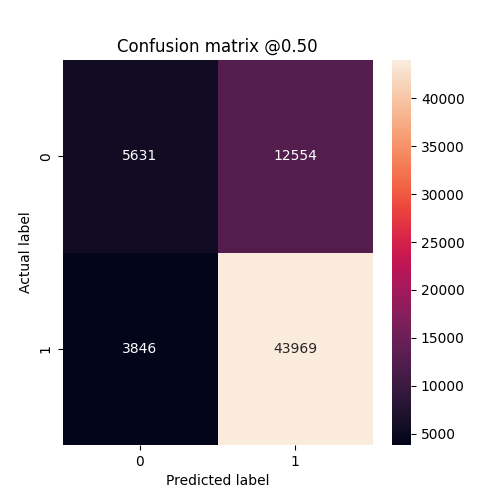

No Flow Detected (True Negatives):  5631
Flow Incorrectly Detected (False Positives):  12554
No Flow Incorrectly Detected (False Negatives):  3846
Flow Detected (True Positives):  43969
Total Flow Detected:  47815
0.7515151515151515


In [134]:
balanced_model.plot_cm()

## Autoencoder

In [135]:
balanced_model = Model(name = "Balanced Model2", num_classes = 2)

balanced_model.split_transform_data(powder_balanced_df)

balanced_model.apply_Scaler()

train_x = balanced_model.train_features

# input layer 
input_layer = keras.Input(shape=(train_x.shape[1],))

# encoding part
encoded = keras.layers.Dense(100, activation='tanh', activity_regularizer=keras.regularizers.l1(10e-5))(input_layer)
encoded = keras.layers.Dense(50, activation='relu')(encoded)

# decoding part
decoded = keras.layers.Dense(50, activation='tanh')(encoded)
decoded = keras.layers.Dense(100, activation='tanh')(decoded)

# output layer
output_layer = keras.layers.Dense(train_x.shape[1], activation='relu')(decoded)

Training labels shape: (211200,)
Validation labels shape: (52800,)
Test labels shape: (66000,)
Training features shape: (211200, 27)
Validation features shape: (52800, 27)
Test features shape: (66000, 27)


In [136]:
from keras.models import Model, Sequential

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [137]:
x = cleaned_df.drop(["Flow Class"], axis=1)
y = cleaned_df["Flow Class"].values
x_scale = MinMaxScaler().fit_transform(x.values)
x_noflow, x_flow = x_scale[y == 0], x_scale[y == 1]

In [138]:
autoencoder.fit(x_noflow, x_noflow, 
                batch_size = 256, epochs = 20, 
                shuffle = True, validation_split = 0.20);

Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2203 - val_loss: 0.1983
Epoch 2/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2028 - val_loss: 0.1838
Epoch 3/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1889 - val_loss: 0.1730
Epoch 4/20
375/375 [==============================] - 1s 1ms/step - loss: 0.1786 - val_loss: 0.1645
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1642 - val_loss: 0.1473
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1504 - val_loss: 0.1389
Epoch 7/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1442 - val_loss: 0.1354
Epoch 8/20
375/375 [==============================] - 1s 1ms/step - loss: 0.1417 - val_loss: 0.1341
Epoch 9/20
375/375 [==============================] - 1s 1ms/step - loss: 0.1407 - val_loss: 0.1337
Epoch 10/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1404 - val_loss: 0.1336

In [139]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [162]:
print(x_noflow.shape)
print(x_flow.shape)
no_flow = hidden_representation.predict(x_noflow[:10000])
flow_ = hidden_representation.predict(x_flow[:10000])

(119983, 27)
(151450, 27)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[-14.957 -15.911 -14.603]
 [-21.6   -13.034   0.892]
 [-19.113 -14.317  -0.301]
 ...
 [  6.279   1.078   0.582]
 [  6.234   1.118   0.59 ]
 [  6.287   1.069   0.582]]


<IPython.core.display.Javascript object>


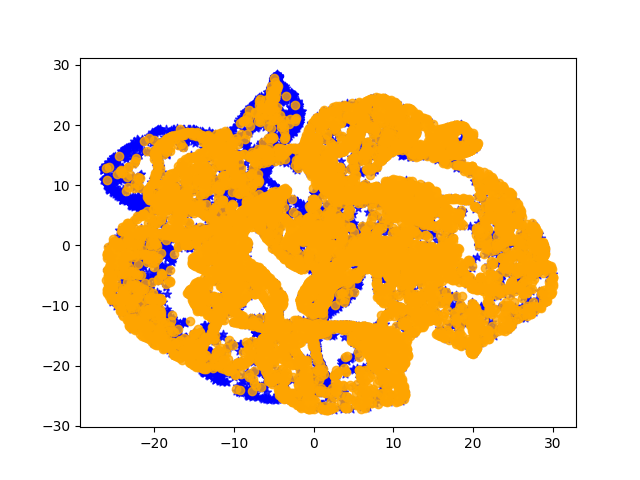

In [161]:
def plot_tsne(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    print(X_t)
    fig = plt.figure()
    
    
#     print(X_t[np.where(y1 == 0), 0])
    plot_ = plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='*', color="blue", alpha=0.8, label='No Flow')
    plot_ = plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='orange', alpha=0.8, label='Flow')

#     plt.legend(loc='best');
#     plt.savefig(name);
    
    plt.show();
    
# print(np.append(y[:10000], y[261433:]))
plot_tsne(pd.concat([x[:10000], x[261433:]]), np.append(y[:10000], y[261433:]), "original.png")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[ -9.778   2.938  -6.624]
 [ -9.813  -6.676  -6.665]
 [ -4.678   4.222  -8.611]
 ...
 [  2.471 -13.396   8.316]
 [ 12.331  16.704   3.757]
 [  0.663  12.467   9.066]]


<IPython.core.display.Javascript object>


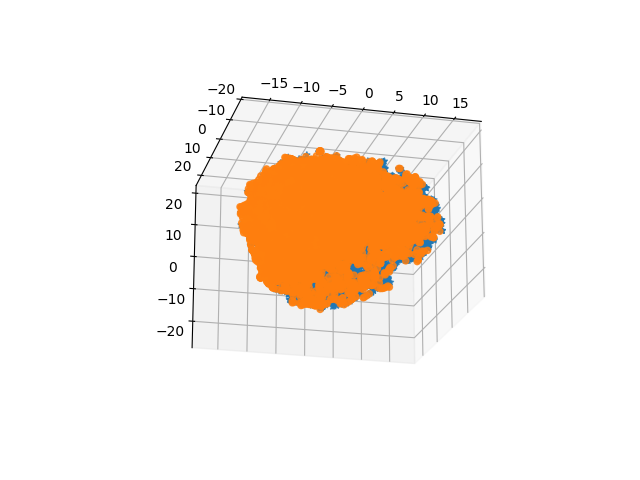

In [163]:
from sklearn.manifold import TSNE
import matplotlib.animation as animation

def plot_tsne(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=3, random_state=0)
    X_t = tsne.fit_transform(x1)
    print(X_t)
    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(45,60)
    
#     print(X_t[np.where(y1 == 0), 0])
    plot_ = ax.scatter3D(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], X_t[np.where(y1 == 0), 2], marker='*', cmap='YlOrRd', alpha=0.8, label='No Flow')
    plot_ = ax.scatter3D(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], X_t[np.where(y1 == 1), 2], marker='o', cmap='BuPu', alpha=0.8, label='Flow')

#     plt.legend(loc='best');
#     plt.savefig(name);
    
    plt.show();
    
    
x_data = np.append(no_flow, flow_, axis = 0)
y_noflow = np.zeros(no_flow.shape[0])
y_flow = np.ones(flow_.shape[0])
y_data = np.append(y_noflow, y_flow)

plot_tsne(x_data, y_data, "./latent_representation.png")



<IPython.core.display.Javascript object>


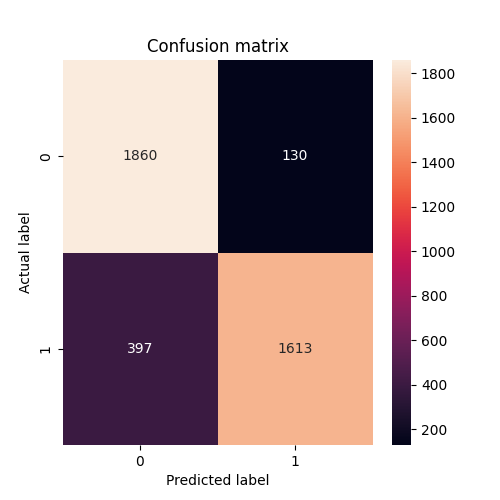

No Flow Detected (True Negatives):  1860
Flow Incorrectly Detected (False Positives):  130
No Flow Incorrectly Detected (False Negatives):  397
Flow Detected (True Positives):  1613
Total Flow Detected:  2010
0.86825


In [142]:
from sklearn.linear_model import LogisticRegression

train_x, val_x, train_y, val_y = train_test_split(x_data, y_data, test_size=0.2)

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

cm = confusion_matrix(val_y, pred_y)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

In [143]:
model = keras.Sequential([
          keras.layers.Dense(
              256, activation='tanh',
              input_shape=(train_x.shape[-1],)),
        keras.layers.Dense(
              128, activation='tanh'),
        keras.layers.Dense(
              64, activation='tanh'),
        keras.layers.Dense(
              32, activation='tanh'),
         keras.layers.Dense(
              16, activation='tanh'),
              keras.layers.Dense(
              8, activation='tanh'),
#           keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation='sigmoid'),
      ])

model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])

model.fit(train_x,
    train_y,
    batch_size=1024,
    epochs=100)

results = model.evaluate(train_x, train_y, batch_size = 1024, verbose=0)


Epoch 1/100
16/16 [==============================] - 1s 5ms/step - loss: 0.6981 - accuracy: 0.5043
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6822 - accuracy: 0.5847
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6678 - accuracy: 0.6301
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6531 - accuracy: 0.6305
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6394 - accuracy: 0.6347
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6437
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6469
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6085 - accuracy: 0.6556
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6002 - accuracy: 0.6646
Epoch 10/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5909 - accuracy: 0.6761
Epoch 11/

16/16 [==============================] - 0s 5ms/step - loss: 0.2057 - accuracy: 0.9330
Epoch 84/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2039 - accuracy: 0.9338
Epoch 85/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1990 - accuracy: 0.9368
Epoch 86/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2000 - accuracy: 0.9351
Epoch 87/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2012 - accuracy: 0.9352
Epoch 88/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2006 - accuracy: 0.9346
Epoch 89/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1968 - accuracy: 0.9384
Epoch 90/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1968 - accuracy: 0.9373
Epoch 91/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2016 - accuracy: 0.9336
Epoch 92/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2007 - accuracy: 0.9348
Epoch 93/100


[[0.971]
 [0.032]
 [0.031]
 ...
 [0.266]
 [0.043]
 [0.036]]


<IPython.core.display.Javascript object>


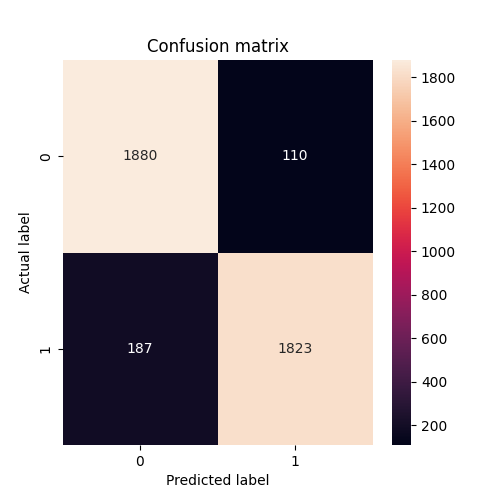

No Flow Detected (True Negatives):  1880
Flow Incorrectly Detected (False Positives):  110
No Flow Incorrectly Detected (False Negatives):  187
Flow Detected (True Positives):  1823
Total Flow Detected:  2010
0.92575


In [144]:
pred_y = model.predict(val_x)
print(pred_y)

cm = confusion_matrix(val_y, pred_y > 0.5)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

In [145]:
import kerastuner as kt

def model_builder1(hp):
    model = keras.Sequential([
          keras.layers.Dense(
              256, activation=hp.Choice('act_0', ['relu', 'sigmoid', 'tanh']),
              input_shape=(train_x.shape[-1],)),
        keras.layers.Dense(
              128, activation=hp.Choice('act_1', ['relu', 'sigmoid', 'tanh'])),
        keras.layers.Dense(
              64, activation=hp.Choice('act_2', ['relu', 'sigmoid', 'tanh'])),
        keras.layers.Dense(
              32, activation=hp.Choice('act_3', ['relu', 'sigmoid', 'tanh'])),
         keras.layers.Dense(
              16, activation=hp.Choice('act_4', ['relu', 'sigmoid', 'tanh'])),
              keras.layers.Dense(
              8, activation=hp.Choice('act_5', ['relu', 'sigmoid', 'tanh'])),
#           keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation=hp.Choice('act_6', ['relu', 'sigmoid', 'tanh']))
              ])
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])
    return model

In [146]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder1, # the hypermodel
                     objective='val_accuracy', # objective to optimize
                        max_epochs=20,
                        factor=3, # factor which you have seen above 
                        directory='dir/fin', # directory to save logs 
                        project_name='hyperband')

# hypertuning settings
tuner.search_space_summary() 

INFO:tensorflow:Reloading Oracle from existing project dir/fin/hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from dir/fin/hyperband/tuner0.json
Search space summary
Default search space size: 8
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_3 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_4 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_5 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
act_6 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'def

In [147]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(train_x, train_y, epochs=10, validation_split=0.2, callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


In [148]:
best_hp=tuner.get_best_hyperparameters()[0]# Build the model with the optimal hyperparameters

In [149]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
h_model.fit(train_x, train_y, epochs=50, validation_split=0.2)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 256)               13056     
                                                                 
 dense_82 (Dense)            (None, 128)               32896     
                                                                 
 dense_83 (Dense)            (None, 64)                8256      
                                                                 
 dense_84 (Dense)            (None, 32)                2080      
                                                                 
 dense_85 (Dense)            (None, 16)                528       
                                                                 
 dense_86 (Dense)            (None, 8)                 136       
                                                                 
 dense_87 (Dense)            (None, 1)               

Epoch 49/50
400/400 [==============================] - 1s 2ms/step - loss: 0.2036 - accuracy: 0.9297 - val_loss: 0.2024 - val_accuracy: 0.9347
Epoch 50/50
400/400 [==============================] - 1s 2ms/step - loss: 0.2061 - accuracy: 0.9307 - val_loss: 0.2284 - val_accuracy: 0.9109


In [150]:
h_eval_dict = h_model.evaluate(val_x, val_y, return_dict=True)

125/125 [==============================] - 0s 1ms/step - loss: 0.2526 - accuracy: 0.9028


[[0.986]
 [0.052]
 [0.052]
 ...
 [0.119]
 [0.058]
 [0.053]]


<IPython.core.display.Javascript object>


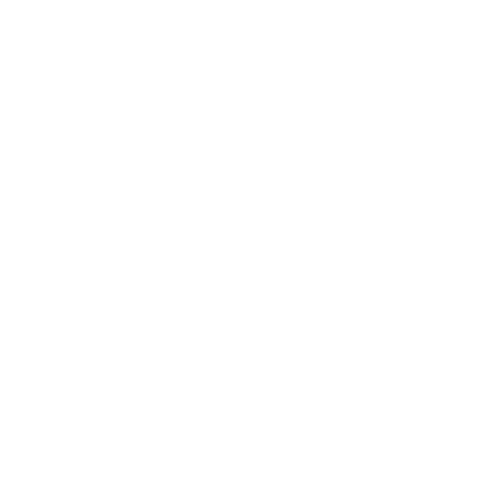

No Flow Detected (True Negatives):  1929
Flow Incorrectly Detected (False Positives):  61
No Flow Incorrectly Detected (False Negatives):  328
Flow Detected (True Positives):  1682
Total Flow Detected:  2010
0.90275


In [151]:
pred_y = h_model.predict(val_x)
print(pred_y)

cm = confusion_matrix(val_y, pred_y > 0.5)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))